# Training and using a LoRA with Stable-Diffusion

In this notebook, we will see how to train Stable-Diffusion with LoRA (Low-Rank Adaptation of Large Language Models).

The idea of LoRA is to inject weight decomposition matrices into the cross-attention layers of the U-Net model in the diffuser and only train those on new image-text pairs. The rest of the model is kept frozen.

Training with LoRA has several advantages:
- Less parameters to train
    - It is **memory efficient** (11GB of VRAM is enough to train a model)!
    - New parameters are portable (~3MB file)
- Can work on top of a base diffusion model at inference
    - Can also control the relative importance of original/matrix decomposition weights via a scale parameter.
- It avoids catastrophic forgetting by freezing the model's parameters

Despite all these advantages, training diffusion models with LoRA is quite complex and involves a lot of steps. Luckly, Huggingface provides a nice training script that is already set up to work with Huggingface Models/Datasets for training our own LoRA. We will see how to run the trianing script and how to apply the model after training.


### How and why should you apply this?

What is the point of fine-tuning a zero-shot diffusion model?  
I will for sure lose some of its generalization capabilities!

Yes, its _very_ true, and if you need a general model, that's the way to go, BUT...  
A few use cases where this may be useful:
- I need to generate specific looking images (e.g., an art style) but I cannot replicate it with the zero-shot model and I have a datasest of image-caption pairs that I want to replicate
- I just want to nerd out and train a model for my purposes (perfectly reasonable)

    
### What can you learn from the notebook

The notebook shows how to:
1. Use the Huggingface LoRA training script
    1. Starting from an available Huggingface `Model`
    1. Using an available Huggingface `Dataset`
1. Load the Model+LoRA and generate images
    1. Playing with the scale parameters

### What's not in notebook

In this notebook, you will not find:
1. How to train the LoRA with your own data on disk (but instructions are here)
1. A hand-crafted LoRA training and evaluation loop


## Table of Contents
* [Requirements](#requirements)
* [The pokémon Dataset](#dataset)
* [Zero-Shot stable-diffusion](#zeroshot)
* [Fine-tuning Stable-Diffusion with LoRA](#finetune)
* [Using the LoRA](#evaluation)

## Requirements<a class="anchor" id="requirements"></a>

To train a LoRA model with the Huggingface script, you need to install a few libraries.

The main libraries you need are:
- Diffusers: the Huggingface sibling of Transformers, specifically developed for diffusion models
    - Huggingface suggests to install from source, but a simple `pip install --upgrade diffusers` should be ok
- [Accelerate](https://huggingface.co/docs/accelerate/index) (optional, but strongly recommended): a Huggingface library to enable parallelism on multi GPUs/TPUs environments with zero code
    - It still works even with no GPUs

In [ ]:
import sys
!{sys.executable} -m pip install --upgrade diffusers accelerate

In [1]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np

import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler

/home/bondielli/virtual-environments/lecturesCL-venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Then you have to config the Accelerate library. You can play with the configurations (see the [Documentation](https://huggingface.co/docs/accelerate/index), or you can set the default configuration that should work ok in most cases

## The Pokémon dataset<a class="anchor" id="dataset"></a>

For this example we will use a dataset including Pokémon images and captions.  
Captions were automatically generated with BLIP.

The dataset can be found [here](https://huggingface.co/datasets/lambdalabs/pokemon-blip-captions). Big thanks to [LambdaLabs](https://lambdalabs.com/) for creating the dataset. There is also a Naruto-based dataset.

Let's take a look at what's inside.

In [2]:
dataset = load_dataset("lambdalabs/pokemon-blip-captions")
dataset

Found cached dataset parquet (/home/bondielli/.cache/huggingface/datasets/lambdalabs___parquet/lambdalabs--pokemon-blip-captions-10e3527a764857bd/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|█████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 558.94it/s]


DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 833
    })
})

The dataset isn't split. Let's see how the images and data look.

In [3]:
def show_images(images, cols = 1, titles = None):
    """Display a list of images in a single figure with matplotlib.
    
    Parameters
    ---------
    images: List of np.arrays compatible with plt.imshow.
    
    cols (Default = 1): Number of columns in figure (number of rows is 
                        set to np.ceil(n_images/float(cols))).
    
    titles: List of titles corresponding to each image. Must have
            the same length as titles.
    """
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure(figsize=(5,5))
    fig.tight_layout()
    
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(int(np.ceil(n_images/float(cols))), cols, n + 1)
        #a.set_title(title, wrap = True, loc = "left")
        a.text(0.5, 1, title, fontsize = 18,
               horizontalalignment='center', 
               verticalalignment='center', 
               transform=a.transAxes,
               wrap = True,
               bbox=dict(facecolor='white', alpha=0.9,  boxstyle='round'))
        plt.axis('off')
        plt.imshow(image)
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

Loading cached shuffled indices for dataset at /home/bondielli/.cache/huggingface/datasets/lambdalabs___parquet/lambdalabs--pokemon-blip-captions-10e3527a764857bd/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-6b44bcff85ccd69a.arrow


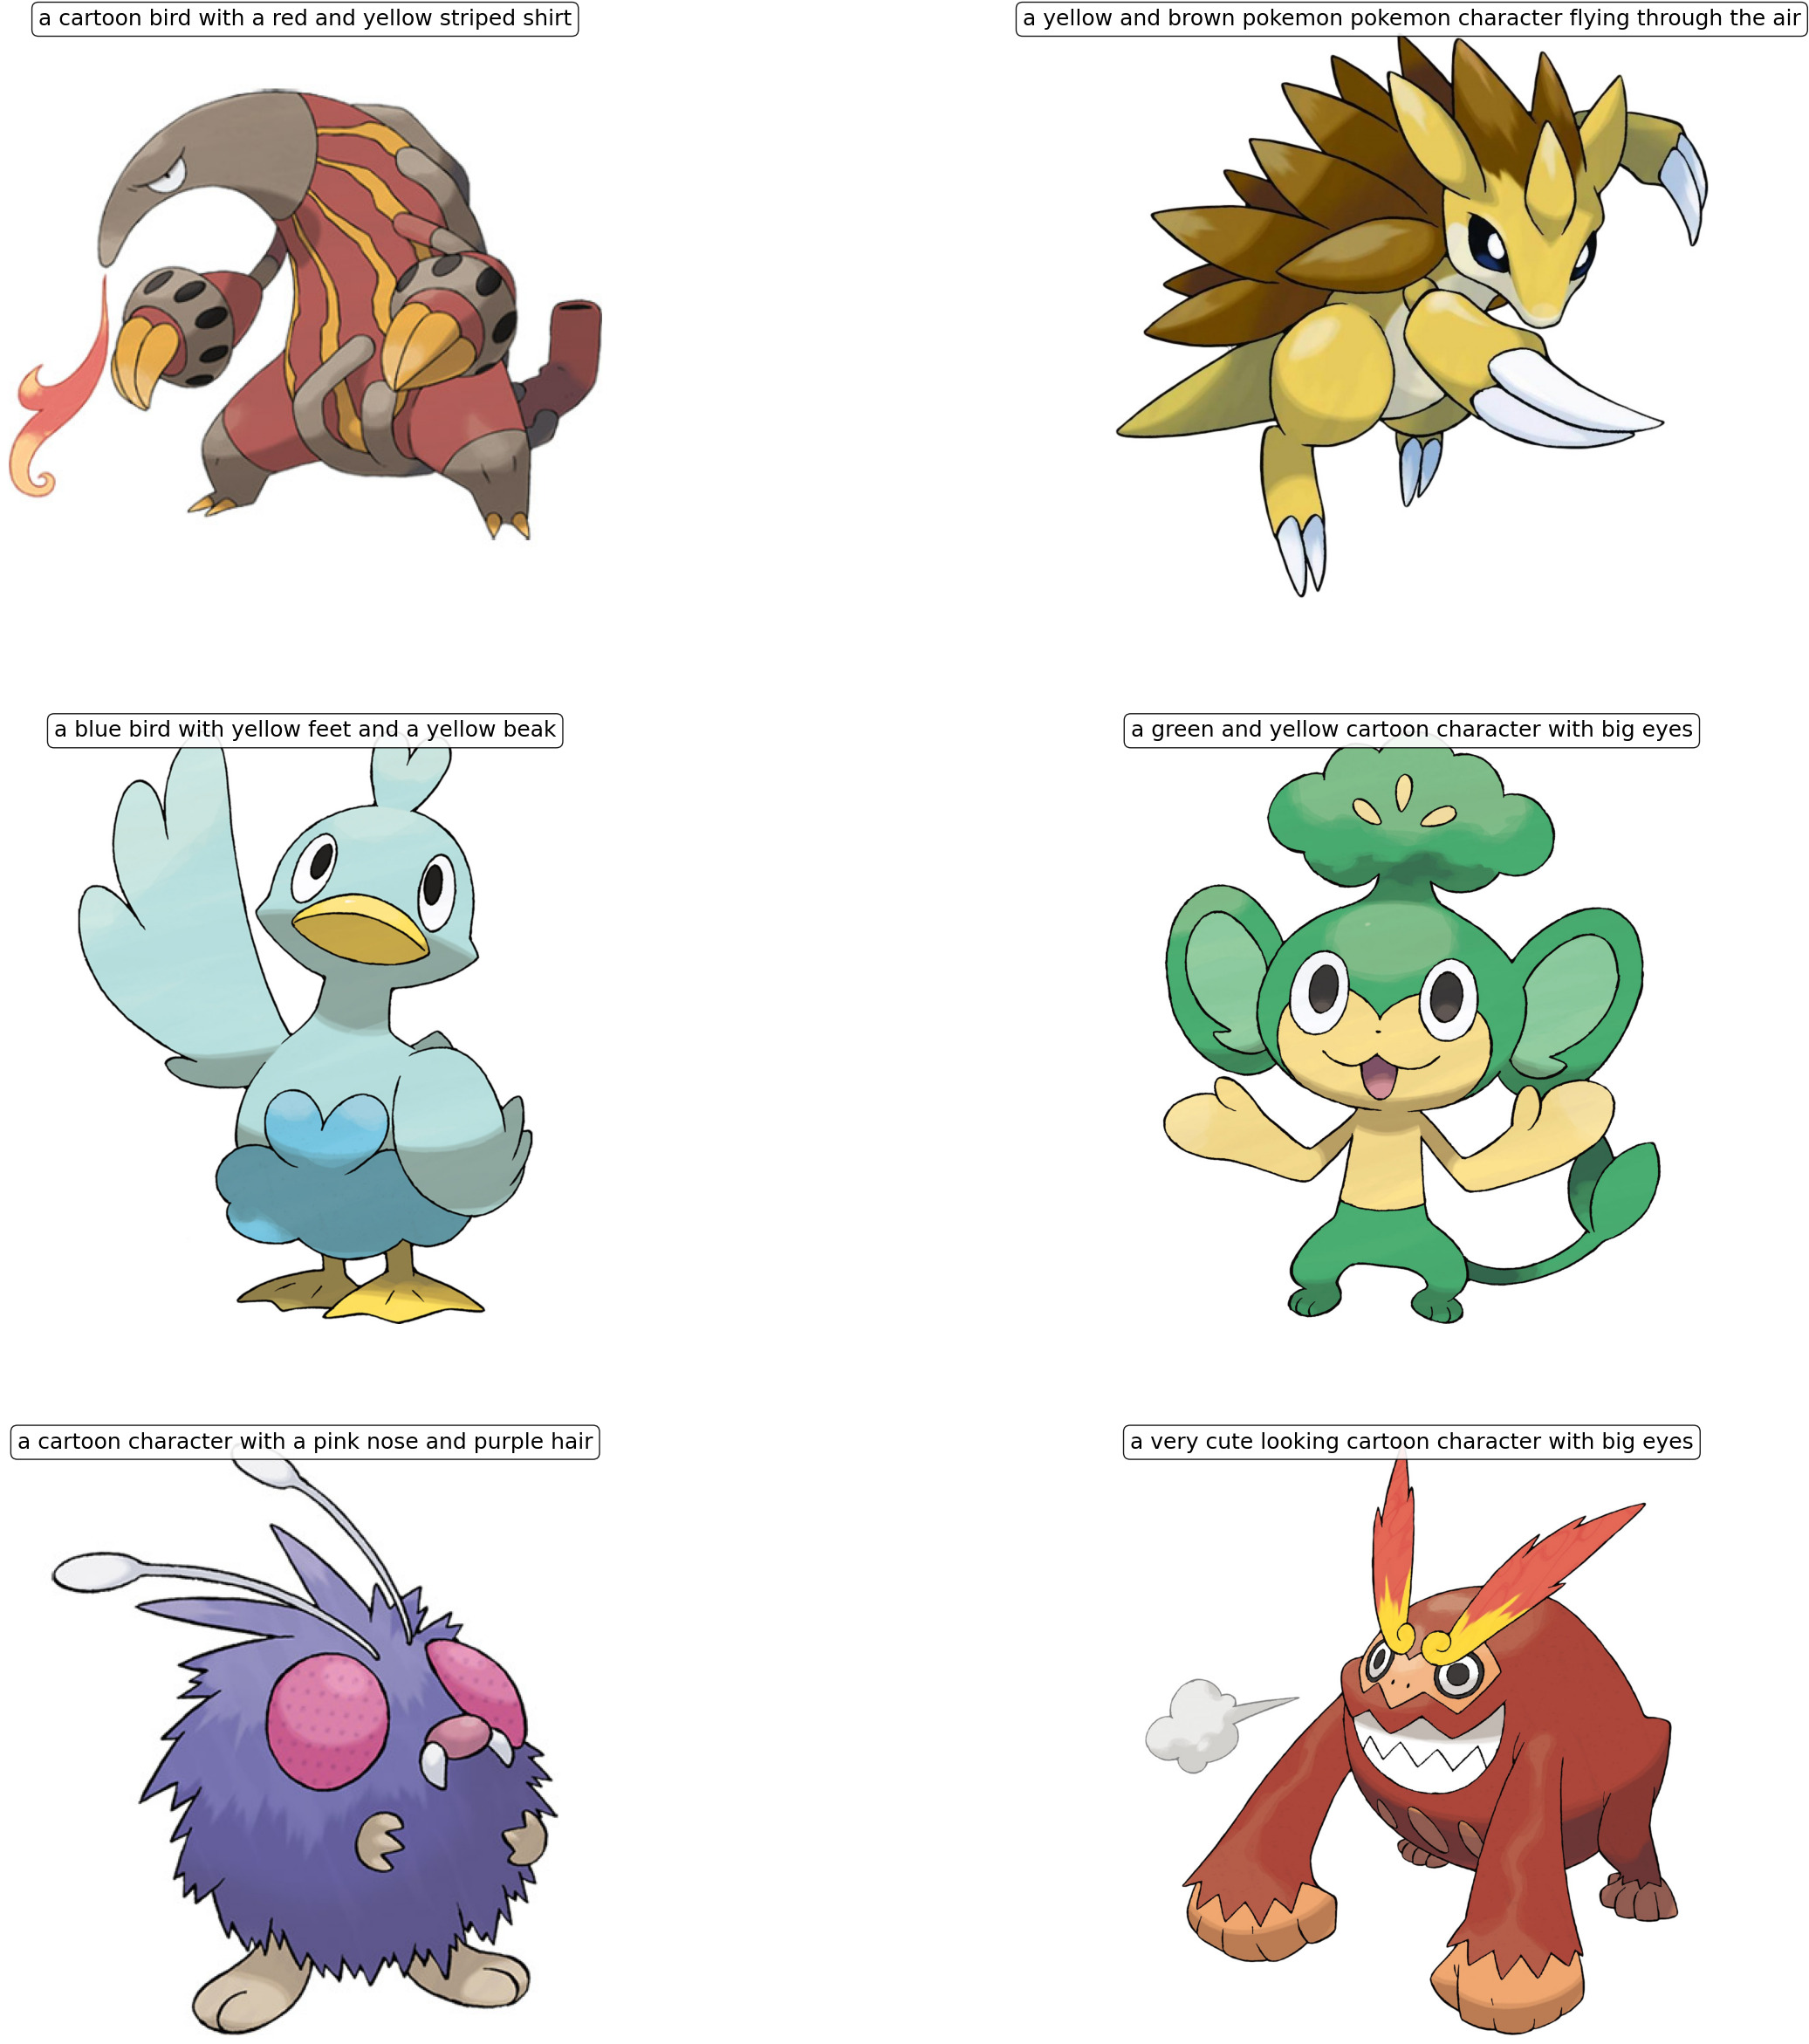

In [4]:
sample = dataset['train'].shuffle(seed=13)[:6]

show_images(sample['image'], cols = 2, titles = sample['text'])

## Zero-shot stable-diffusion<a class="anchor" id="zeroshot"></a>

Now we try to generate a Pokémon with the base [Stable-Diffusion 2.1 model](https://huggingface.co/stabilityai/stable-diffusion-2-1) on huggingface.

We can use pipelines for this.  
First we load the model into a `StableDiffusionPipeline`. Then we load a scheduler for the pipeline, and send the pipeline to cuda (for GPU acceleration).

In [5]:
model_name = "stabilityai/stable-diffusion-2-1-base"

pipe = StableDiffusionPipeline.from_pretrained(model_name, torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

pipe.to("cuda")

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.17.0.dev0",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": false,
  "safety_checker": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "DPMSolverMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

Then we prompt it and see what it gives us

100%|████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 33.53it/s]


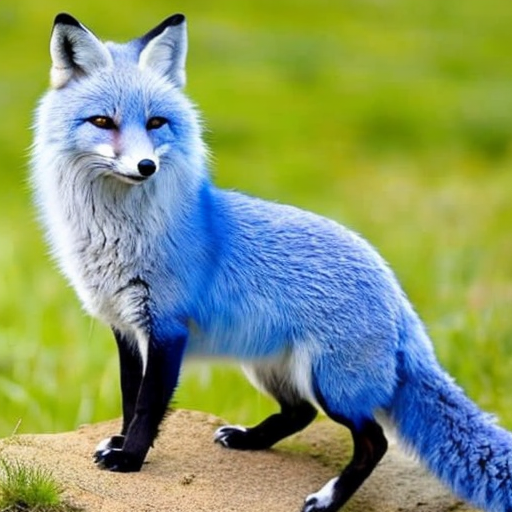

In [7]:
prompt = "a pokemon that looks like a cute blue fox, with golden eyes and a long tail"
neg_prompt = '''ugly, poorly rendered eyes, tiling, poorly drawn hands, 
                poorly drawn feet, poorly drawn face, out of frame, extra limbs, 
                disfigured, deformed, body out of frame, blurry, bad anatomy, blurred, 
                watermark, grainy, signature, cut off, draft'''

image = pipe(
    prompt, 
    negative_prompt = neg_prompt, 
    num_inference_steps=50, 
    guidance_scale=7.5
).images[0]
image

## Fine-tuning Stable-Diffusion with LoRA<a class="anchor" id="finetune"></a>

Now we dive into how to fine-tune the stable-diffusion model with LoRA on our Pokémon dataset.

We will use the [scrpit provided by Huggingface](https://github.com/huggingface/diffusers/blob/main/examples/text_to_image/train_text_to_image_lora.py)

The script can be run via CLI by providing a set of arguments that it will use as parameters for the model.  
You can see all parameters in the script helper (`--help`).

Here we will focus on the key parameters for the training:

- `pretrained_model_name_or_path`: the name of pretrained model from Huggingface (or a path to your locally store model)
- `dataset_name`: the name of the training dataset from Huggingface (or a path to your locally store dataset)
- `caption_column` and `image_column`: names of the text and image columns in the dataset. This is important especially if your dataset has non-standard column names (default are 'text' and 'image'
- `resolution`: size of input and output images. For SD < 2.0 is 512px, for SD > 2.0 is 768
- `random_flip` and `center_crop`: to randomly flip images and crop them (data augmentation, improves quality of results)
- `train_batch_size`: The batch size for training. No 
- `num_train_epochs`: How many epochs to train the model for
- `checkpointing_steps`: the model is saved every $n$ steps
- `learning_rate`: Training learning rate
    - For training a LoRA, it's ok to train with a higher learning rate tha usual (e.g., one order of magnitude higher)
- `lr_scheduler`: scheduler for the learning rate
- `lr_warmup_steps`: number of warmup steps, here we keep zero
- `seed`: random seed for reproducibility
- `output_dir`: output directory for the trained model
- `validation_prompt`: a prompt to use for validation. Every epoch the model will generate images based on the prompt (defaults to 4 images)
- `report_to`: where to report (e.g., [Weights and Biases](https://wandb.ai/site))


Before training we can set variables for model name and dataset name:

Finally we can launch the trainer using accelerate

Training of the LoRA model takes roughly 5-6 hours with an A100 GPU (40GB VRAM) with a batch size of 1.

Luckly, we alreadly trained the model and we can start playing with it!

## Using the LoRA<a class="anchor" id="evaluation"></a>

The LoRA weights have to be injected into the _cross attention_ layers.  
To do so, we have to load the model and the scheduler as before. Now we will also use the `Pipeline.unet.load_attn_procs()` function to specify  

In [8]:
# load the model same as before
model_name = "stabilityai/stable-diffusion-2-1-base"

pipe = StableDiffusionPipeline.from_pretrained(model_name, torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)

pipe.to("cuda")

lora_path = "sd-pokemon-model-lora"
pipe.unet.load_attn_procs(lora_path)

When we generate a new image, we can use the `scale` parameter (one of the `crosss_attention_kwargs`) to choose the how much of the new weights we want to use:
- `scale = 0` --> Use the original model weights only
- `scale = 1` --> Use the LoRA weights only

100%|████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.49it/s]


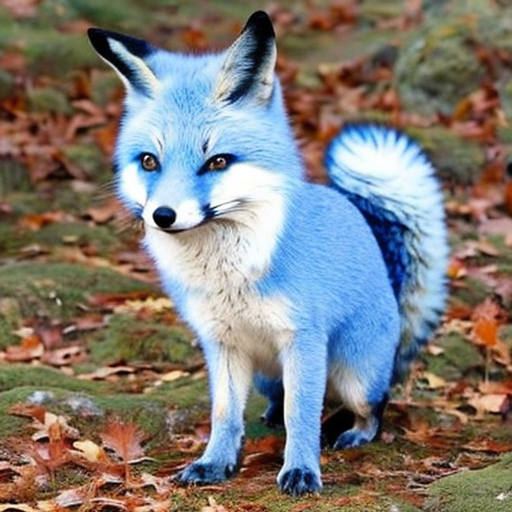

In [9]:
prompt = "a pokemon that looks like a cute blue fox, with golden eyes and a long tail"
neg_prompt = '''ugly, poorly rendered eyes, tiling, poorly drawn hands, 
                poorly drawn feet, poorly drawn face, out of frame, extra limbs, 
                disfigured, deformed, body out of frame, blurry, bad anatomy, blurred, 
                watermark, grainy, signature, cut off, draft'''
image = pipe(
    prompt, negative_prompt = neg_prompt, 
    num_inference_steps=50, 
    guidance_scale=7.5, 
    cross_attention_kwargs={"scale": 0} # use the original model attention weights
).images[0]
image

Often best results are obtained by using `scale = 0.5`.  
In this case the model uses a mixture of weights from the original model and the LoRA.  
If we leverage both weights equally, we can obtain more realistic results, e.g. Pokémons in a more realistic envornoment.

100%|████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.37it/s]


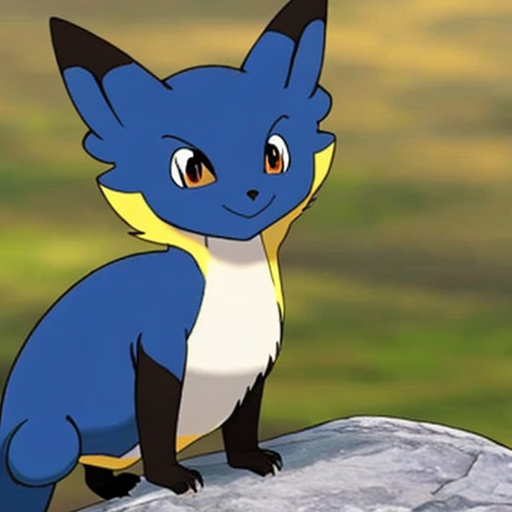

In [10]:
image = pipe(
    prompt, negative_prompt = neg_prompt, 
    num_inference_steps=50, 
    guidance_scale=7.5, 
    cross_attention_kwargs={"scale": 0.5} # use a mixture of weigths from the original model and the LoRA
).images[0]
image

If we use only the weights from the LoRA, it may get a little less creative (e.g. with backgrounds etc.)

100%|████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 22.80it/s]


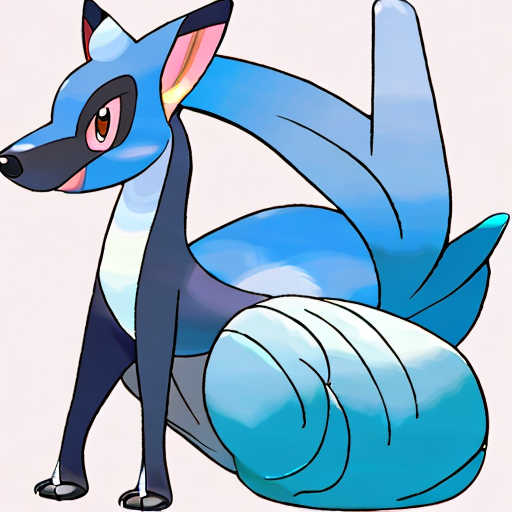

In [11]:
image = pipe(
    prompt, negative_prompt = neg_prompt, 
    num_inference_steps=50, 
    guidance_scale=7.5, 
    cross_attention_kwargs={"scale": 1}
).images[0]
image